# Part 2: Pneumonia Prediction

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from os import listdir
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
from captum.attr import IntegratedGradients

/Users/melanierieff/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Q3 Integrated Gradients (5 Pts)

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [17]:
model = CNN()

# Load saved model
model.load_state_dict(torch.load("part2_cnn_weights/CNN_weights.pth", weights_only=True))
model.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Resize the image
    img = cv2.resize(img, (1000, 1000))

    # Convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Histogram Equalization
    img = cv2.equalizeHist(img)

    # Gaussian Blur (5x5 kernel)
    final_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return final_img

In [19]:
# Testing label of a single image

input_img = preprocess_image("data_part2/train/PNEUMONIA/person1228_virus_2079.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)

# Note that 0 = NORMAL, 1 = PNEUMONIA
output = model(input_img)
predicted = (output > 0.5).float()
print("Predicted:", predicted.item())

Predicted: 1.0


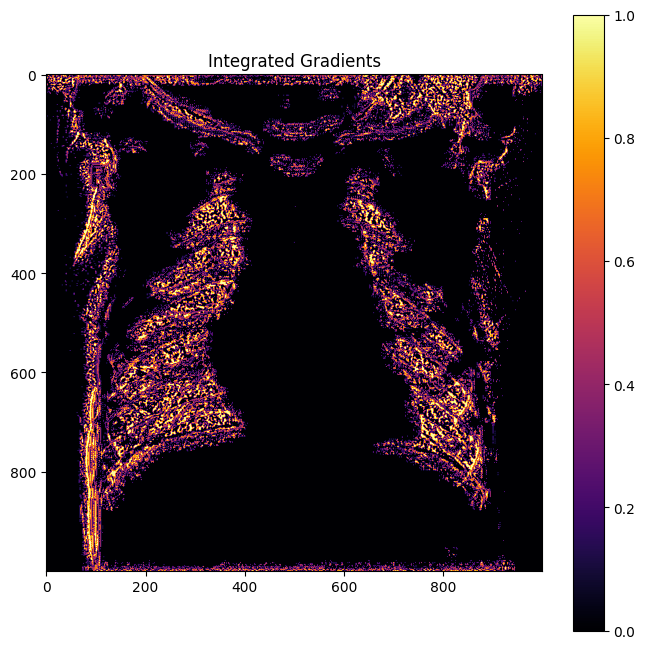

In [ ]:
# Printing integrated gradients for a single image (for testing purposes)

input_img = Image.open("data_part2_processed/train/NORMAL/IM-0117-0001.jpeg")
transform = transforms.ToTensor()
input_img = transform(input_img).unsqueeze(0)


#baseline = torch.rand_like(input_img)
blurred = TF.gaussian_blur(input_img.squeeze(0), kernel_size=9)
baseline = blurred.unsqueeze(0)
integrated_gradients = IntegratedGradients(model)

attributions, delta = integrated_gradients.attribute(
    input_img,
    baselines=baseline,
    target=0,
    return_convergence_delta=True
)

attr = attributions.squeeze().detach().cpu().numpy()
attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)

plt.figure(figsize=(8, 8))
threshold = np.percentile(attr_norm, 90)
plt.imshow(attr_norm > threshold, cmap="inferno")
plt.colorbar()
plt.title("Integrated Gradients")
plt.show()

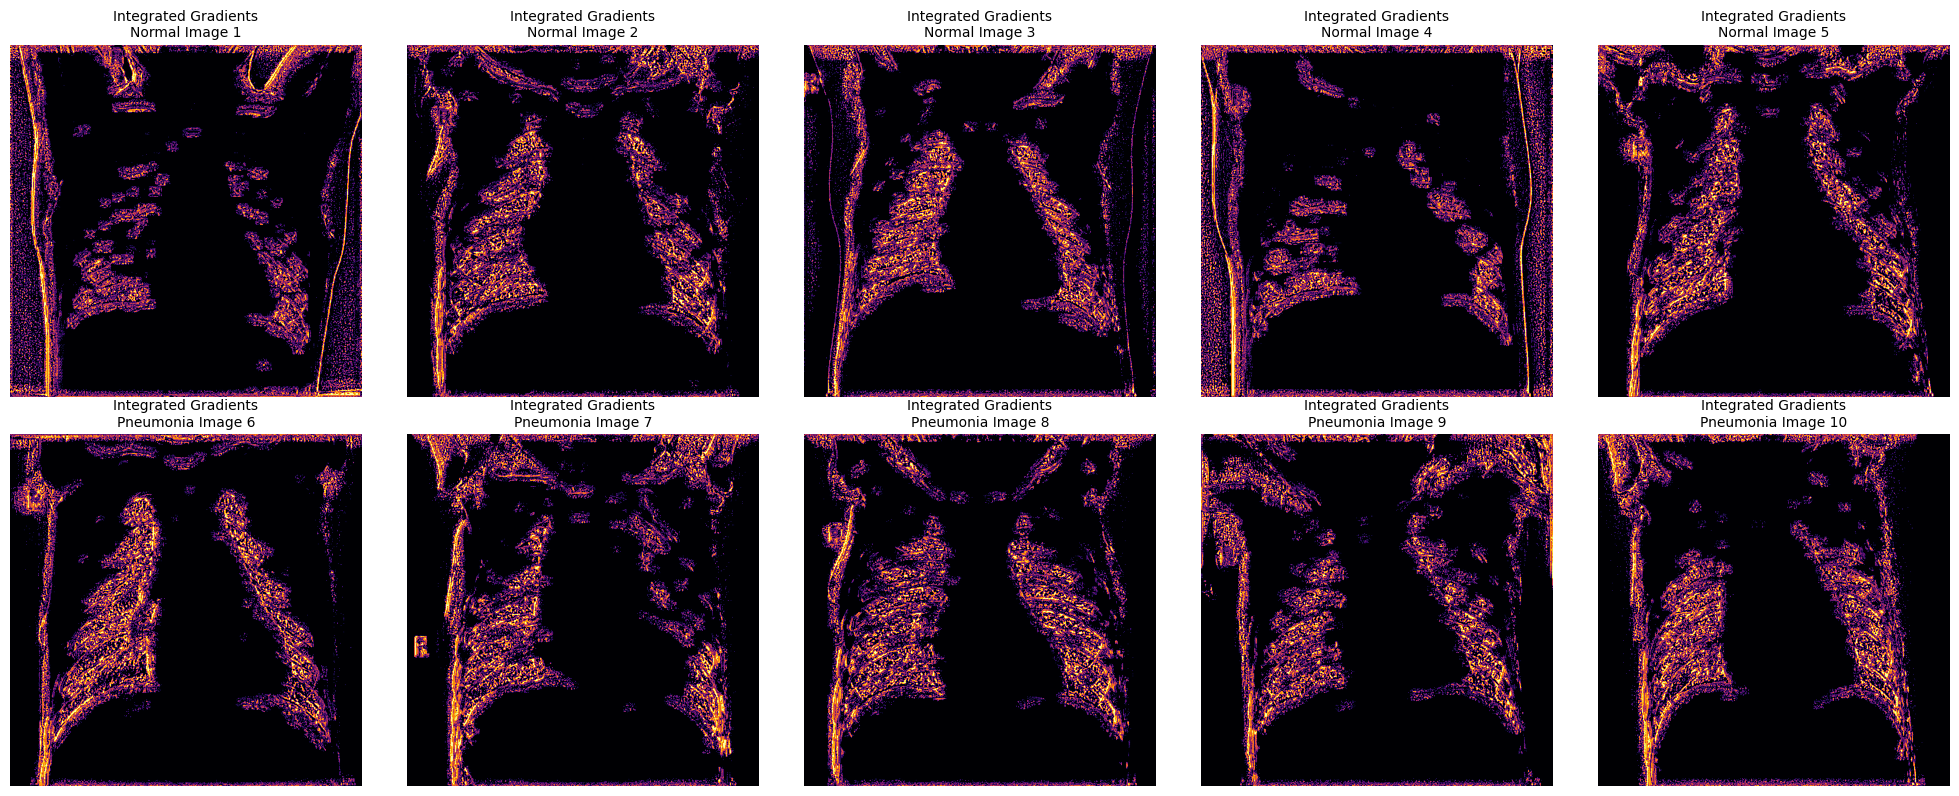

In [ ]:
# Plotting the integrated gradients for 5 normal and 5 pneumonia images

data_dir = "data_part2_processed/train"
normal_dir = os.path.join(data_dir, "NORMAL")
pneumonia_dir = os.path.join(data_dir, "PNEUMONIA")

# Loading 5 normal and 5 pneumonia image filenames
normal_images = sorted([f for f in os.listdir(normal_dir)])

pneumonia_images = sorted([f for f in os.listdir(pneumonia_dir)])

all_image_paths = [os.path.join(normal_dir, f) for f in normal_images] + \
                  [os.path.join(pneumonia_dir, f) for f in pneumonia_images]

labels = ["Normal"] * 5 + ["Pneumonia"] * 5

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, (image_path, label) in enumerate(zip(all_image_paths, labels)):
    input_img = Image.open(image_path)
    transform = transforms.ToTensor()
    input_img = transform(input_img).unsqueeze(0)

    # Blur image as a baseline
    blurred = TF.gaussian_blur(input_img.squeeze(0), kernel_size=9)
    baseline = blurred.unsqueeze(0)

    # Random baseline 
    """ baseline = torch.rand_like(input_img) """

    # Zero baseline
    """ baseline = torch.zeros_like(input_img) """

    integrated_gradients = IntegratedGradients(model)
    attributions, delta = integrated_gradients.attribute(
        input_img,
        baselines=baseline,
        target=0,
        return_convergence_delta=True
    )

    attr = attributions.squeeze().detach().cpu().numpy()

    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    threshold = np.percentile(attr_norm, 90)

    axes[idx].imshow(attr_norm > threshold, cmap="inferno")
    axes[idx].set_title(f"Integrated Gradients\n{label} Image {idx+1}", fontsize=10)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

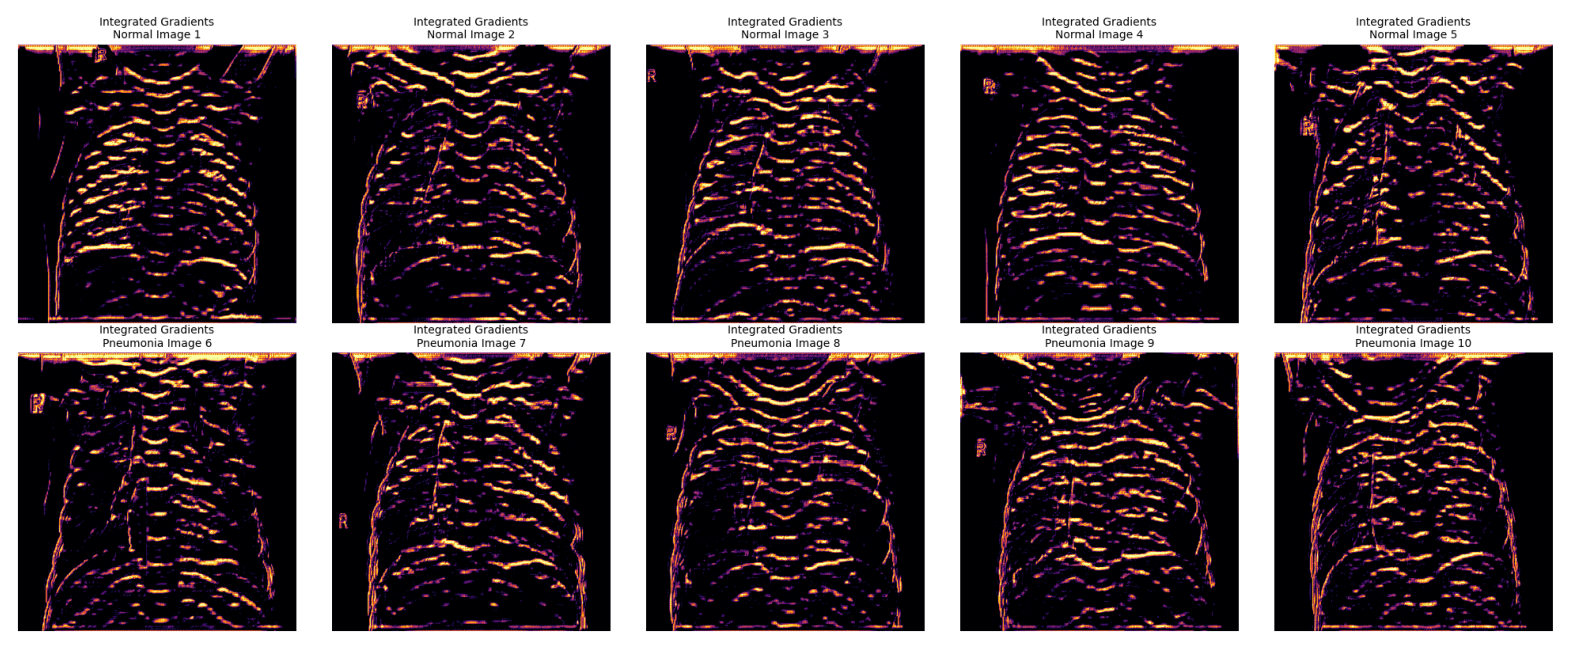

In [22]:
# Zero baseline
img = Image.open("integrated_gradients/zero_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

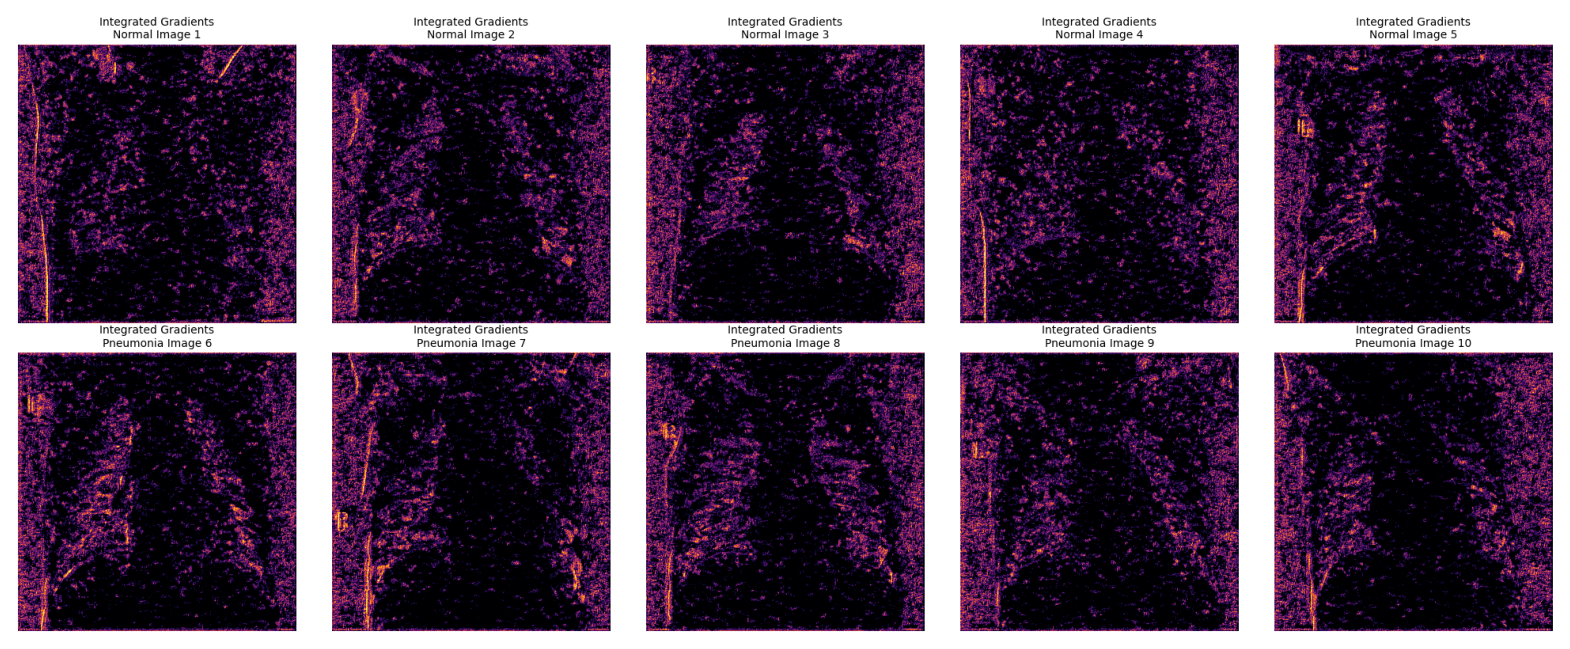

In [23]:
# Ranodm baseline
img = Image.open("integrated_gradients/random_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

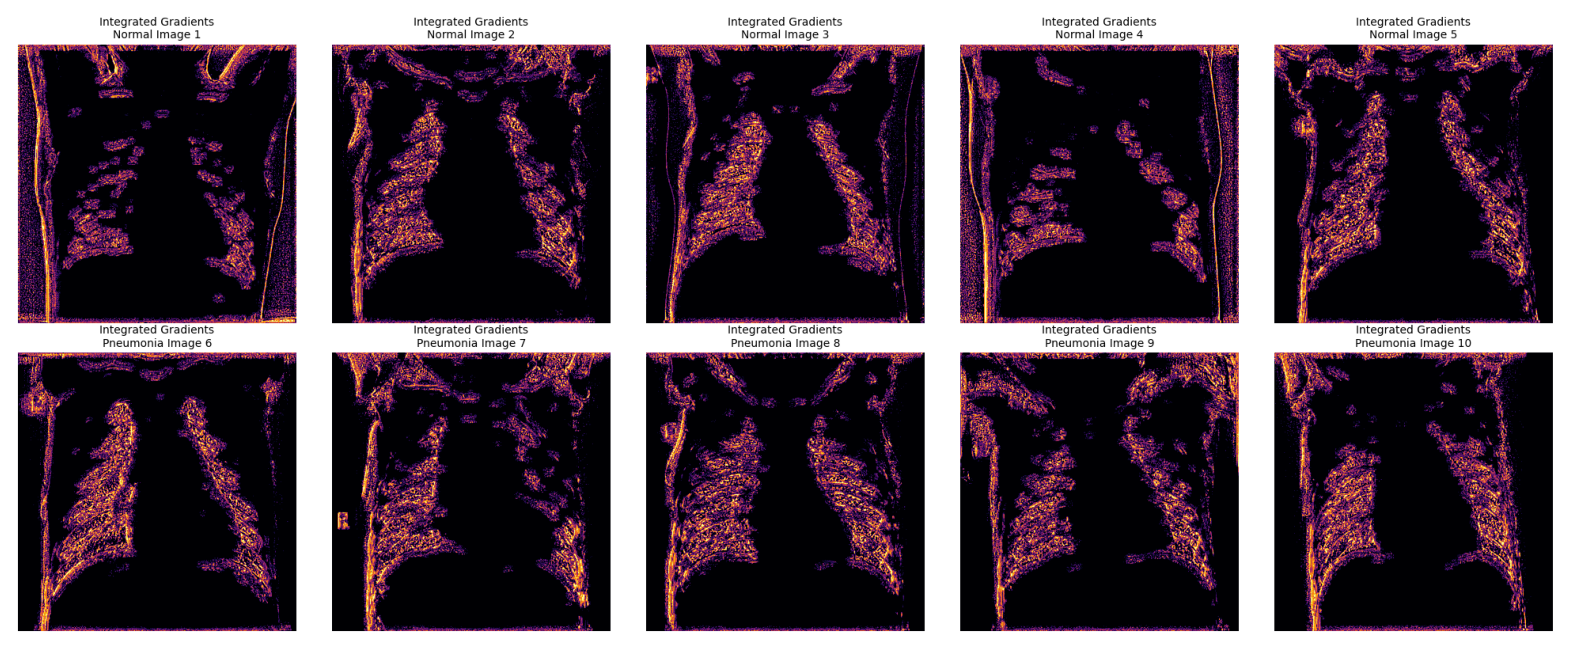

In [24]:
# blurred baseline
img = Image.open("integrated_gradients/blurred_baseline.png")
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis("off")
plt.show()

#### Observations

Q3.2

Above we can see the integrated gradients of five healthy and five disease samples (using zero baseline, random baseline, and blurred baseline). We know that pneumonia is a lung based disease, therefore, we expect the sensible regions to be tissue around where the lungs should be. If we look at the images that were generated using the blurred baseline, we can see that in all images the lungs are nicely highlighted. However, there is not a clear difference between healthy and disease samples.

Q3.3

Across all different baselines, the attributions are consistent across all samples

Q3.4

Yes, the baseline does have a big effect on the attribution maps as we can see in the images. It turns out that the blurred baseline best highlights the lungs of the patients, whereas the zero baseline only highlights the ribcage of the patient. Last but not least, the random baseline focuses alot on the background (i.e., irrelevant part of the image). However, when looking closely we can see that it also focuses on parts of the lungs.